# Итоговый проект. Мария Малафеева

- Для работы в проект были взяты датасеты Тинькофф Банка. Как известно, Тинькоф доставляет свои карты лично клиентам в указанные места. Для этого в Тиньке существует определенная система раздачи карт - они делат территорию на гексагоны. Чтобы оптимизировать отбивание заявок они регулярно вводят новые правила работы гексагонов. 
_____________________________________________________________
- Первый датасет application_date содержит все заявки, которые поступали в банк для оформления карты
- Второй датасет содержит информаци по режиму работы гексагонов

## Установка данных и библиотек 

In [371]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [372]:
applications = pd.read_csv('application_dataset.csv', sep=';')
hexagons = pd.read_csv('hexagons_dataset.csv')

C:\Users\Marusya\AppData\Local\Temp\ipykernel_9664\247189388.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  hexagons = pd.read_csv('hexagons_dataset.csv')


Для начала предлагаю ознакомиться со столбцами датасетов, чтобы понимать с чем мы в дальнейшем будем работать:

In [373]:
df_info = [
    ['request_timestamp', 'дата заявки', 'datetime'],
    ['type', 'тип продукта', 'object / category'],
    ['sch_flg', 'флаг назначения встречи', 'int / bool'],
    ['meet_flg', 'флаг состоявшейся встречи', 'int / bool'],
    ['success_flg', 'флаг успешной встречи (может быть False при состоявшейся встрече)', 'int / bool'],
    ['utlz_flg', 'флаг утилизации продукта', 'int / bool'],
    ['real_utilization_dttm', 'дата утилизации', 'datetime'],
    ['planned_start_date', 'первая назначенная встреча', 'datetime'],
    ['first_success_dttm', 'дата успешной встречи', 'datetime'],
    ['start_interval', 'дата первого доступного интервала', 'datetime'],
    ['hex', 'гексагон заявки', 'object / string']
]


columnsdf = pd.DataFrame(data_info, columns=['Название столбца', 'Описание', 'Тип данных'])
columnsdf


,Название столбца,Описание,Тип данных
0,request_timestamp,дата заявки,datetime
1,type,тип продукта,object / category
2,sch_flg,флаг назначения встречи,int / bool
3,meet_flg,флаг состоявшейся встречи,int / bool
4,success_flg,флаг успешной встречи (может быть False при со...,int / bool
5,utlz_flg,флаг утилизации продукта,int / bool
6,real_utilization_dttm,дата утилизации,datetime
7,planned_start_date,первая назначенная встреча,datetime
8,start_interval,дата первого доступного интервала,datetime
9,hex,гексагон заявки,object / string


In [374]:
hex_df_info = [
    ['hex', 'Гексагон заявки', 'object / string'],
    ['subject', 'Субъект РФ', 'object / category'],
    ['treatment_date', 'Дата изменений', 'datetime'],
    ['region_id_old', 'ID региона до изменений', 'int / string'],
    ['region_id_new', 'ID региона после изменений', 'int / string'],
    ['work_mode_old', 'Режим работы до изменений', 'object / category'],
    ['work_mode_new', 'Режим работы после изменений', 'object / category']
]

# Создание DataFrame с описанием
hex_df = pd.DataFrame(region_data_info, columns=['Название столбца', 'Описание', 'Тип данных'])
hex_df

,Название столбца,Описание,Тип данных
0,hex,Гексагон заявки,object / string
1,subject,Субъект РФ,object / category
2,treatment_date,Дата изменений,datetime
3,region_id_old,ID региона до изменений,int / string
4,region_id_new,ID региона после изменений,int / string
5,work_mode_old,Режим работы до изменений,object / category
6,work_mode_new,Режим работы после изменений,object / category


## Подготовка и очистка данных

- Для того чтобы начать делать какие-то выводы по датасетам, нам необходимо сделать их однородными и найти обoщие пересецения (территория и гексагон)
- Предлагаю сначала переформатировать и поистить датасеты, затем объединить их. То что все даты указаны в формате дататайм - моя догадка, поэтому сразу переформатирую их на всякий случай

In [375]:
# Преобразовываем формат даты на всякий случай, если он не преобразован
applications['request_timestamp'] = pd.to_datetime(applications['request_timestamp'])
applications['planned_start_date'] = pd.to_datetime(applications['planned_start_date'])
applications['real_utilization_dttm'] = pd.to_datetime(applications['real_utilization_dttm'])
hexagons['treatment_date'] = pd.to_datetime(hexagons['treatment_date'])

In [376]:
# Дропаем строки с NaN
applications_clean = applications.dropna()
hexagons_clean = hexagons.dropna()

Теперь яхочу свести информацию по датасетам. Для соединения двух датафреймов по общему столбцу hex. Параметр how='inner' указывает на то, что нужно оставить только те записи, которые есть в обоих датасетах. 

In [377]:
df = pd.merge(applications, hexagons, on='hex', how='inner')

In [378]:
df.head()

,request_timestamp,type,sch_flg,meet_flg,success_flg,utlz_flg,real_utilization_dttm,planned_start_date,first_success_dttm,start_interval,subject_req,hex,Unnamed: 0,subject,treatment_date,region_id_old,work_mode_old,region_id_new,work_mode_new
0,2022-06-23,Debit Card,1,1,1,0,NaT,2022-06-29,2022-06-29,2022-06-28,Республика Башкортостан,88108b6e53fffff,232575,Башкортостан,NaT,138,7,96,7
1,2022-10-10,Debit Card,1,0,0,0,NaT,2022-10-02,NaN,2022-10-12,Алтайский край,880bb2d157fffff,2364913,Алтайский край,2022-10-19,60,7,60,7
2,2022-08-09,Debit Card,0,0,0,0,NaT,NaT,NaN,NaN,Челябинская область,8810decc91fffff,386588,Челябинская область,2022-09-22,417,7,417,7
3,2022-07-15,Debit Card,1,0,0,1,2022-07-15,2022-07-18,NaN,2022-07-16,Томская область,880b86aedbfffff,2951867,Томская область,2022-10-19,62,7,62,7
4,2022-07-12,Debit Card,1,1,1,1,2022-07-14,2022-07-14,2022-07-14,2022-07-14,Курганская область,8810db008dfffff,473640,Курганская область,2022-09-22,88,7,88,7


Теперь у нас есть красивый датасет, где информаци сведена по гексагонам, но если честно мне немного сложно воспринимать общую логику датасета с такими названиями, попробуем переименовать все на русский язык и сразу удалим ненужные столбцы

In [379]:
df.rename(columns={
    'request_timestamp': 'дата заявки',
    'type': 'тип карты',
    'sch_flg': 'встреча назначена',
    'meet_flg': 'встреча состоялась',
    'success_flg': 'встреча состоялась успешно',
    'utlz_flg': 'карта утилизирована',
    'first_success_dttm': 'дата успешной встречи',
    'real_utilization_dttm': 'дата утилизации',
     'subject_req': 'Субъект РФ',
    'planned_start_date': 'дата встречи',
    'start_interval': 'дата первого доступа',    
    'hex': 'гексагон',
    'subject': 'субъект_РФ',
    'treatment_date': 'дата изменений',
    'region_id_old': 'регион до',
    'region_id_new': 'регион после',
    'work_mode_old': 'режим до',
    'work_mode_new': 'режим после'
}, inplace=True)

In [380]:
df = df.drop(columns=['субъект_РФ', 'Unnamed: 0', 'режим после', 'режим до', 'регион до', 'регион после'])

In [381]:
df.head()

,дата заявки,тип карты,встреча назначена,встреча состоялась,встреча состоялась успешно,карта утилизирована,дата утилизации,дата встречи,дата успешной встречи,дата первого доступа,Субъект РФ,гексагон,дата изменений
0,2022-06-23,Debit Card,1,1,1,0,NaT,2022-06-29,2022-06-29,2022-06-28,Республика Башкортостан,88108b6e53fffff,NaT
1,2022-10-10,Debit Card,1,0,0,0,NaT,2022-10-02,NaN,2022-10-12,Алтайский край,880bb2d157fffff,2022-10-19
2,2022-08-09,Debit Card,0,0,0,0,NaT,NaT,NaN,NaN,Челябинская область,8810decc91fffff,2022-09-22
3,2022-07-15,Debit Card,1,0,0,1,2022-07-15,2022-07-18,NaN,2022-07-16,Томская область,880b86aedbfffff,2022-10-19
4,2022-07-12,Debit Card,1,1,1,1,2022-07-14,2022-07-14,2022-07-14,2022-07-14,Курганская область,8810db008dfffff,2022-09-22


Теперь снова создадим два датафрейма, но разобьем их уже по другому принципу: один будет содержать данные до изменений в режиме работы гексагонов, другой после измениний. Так мы сможем посмотреть статистику по обновлениям и узнать динамику 

In [382]:
df_old = df[df['дата встречи'] < df['дата изменений']].copy()
df_new = df[df['дата встречи'] >= df['дата изменений']].copy()

У нас есть два красивых почищенных отформатированных датасета одного вида: 
- df_old для данных, которые были собраны до изменения гексагонов 
- df_new, для данных которые собраны после изменения гексагов 

In [383]:
df_old.head()

,дата заявки,тип карты,встреча назначена,встреча состоялась,встреча состоялась успешно,карта утилизирована,дата утилизации,дата встречи,дата успешной встречи,дата первого доступа,Субъект РФ,гексагон,дата изменений
1,2022-10-10,Debit Card,1,0,0,0,NaT,2022-10-02,NaN,2022-10-12,Алтайский край,880bb2d157fffff,2022-10-19
3,2022-07-15,Debit Card,1,0,0,1,2022-07-15,2022-07-18,NaN,2022-07-16,Томская область,880b86aedbfffff,2022-10-19
4,2022-07-12,Debit Card,1,1,1,1,2022-07-14,2022-07-14,2022-07-14,2022-07-14,Курганская область,8810db008dfffff,2022-09-22
5,2022-05-18,Debit Card,1,0,0,0,NaT,2022-05-21,NaN,2022-05-21,Новосибирская область,880bb036e5fffff,2022-10-19
6,2022-08-16,Debit Card,1,1,1,1,2022-08-23,2022-08-18,2022-08-18,2022-08-18,Кемеровская область,880b946935fffff,2022-10-19


In [384]:
df_new.head()

,дата заявки,тип карты,встреча назначена,встреча состоялась,встреча состоялась успешно,карта утилизирована,дата утилизации,дата встречи,дата успешной встречи,дата первого доступа,Субъект РФ,гексагон,дата изменений
23,2022-08-23,Debit Card,1,1,1,1,2022-08-29,2022-08-29,2022-08-29,2022-08-29,Приморский край,882ec82cd5fffff,2022-08-19
32,2022-09-08,Debit Card,1,0,0,0,NaT,2022-09-11,NaN,2022-09-10,Тюменская область,8810d9a441fffff,2022-08-12
39,2022-10-05,Debit Card,1,0,0,0,NaT,2022-10-07,NaN,2022-10-07,Челябинская область,882121a669fffff,2022-09-22
44,2022-10-14,Debit Card,1,1,1,0,NaT,2022-10-17,2022-10-17,2022-10-17,Хабаровский край,8814d641c9fffff,2022-08-19
57,2022-09-19,Debit Card,1,1,1,1,2022-09-24,2022-09-22,2022-09-24,2022-09-22,Приморский край,88316c0b6bfffff,2022-08-19


## Анализ данных

Теперь, перед тем, как визуализировать статистику мне стало интересно, как долго в среднем гексагоны работают в новом режиме. Эта информация позволит нам прикинуть, насколько реально оценивать продуктивность новой системы  и насколько случайными могут быть данными. Ведь если старая система гексагонов существует несколько лет, а новая пару дней, мы не сможем оценить динамику как последствие новвоведений. Вдруг это просто случайность или другой экономический фактор? Очевидно, что разные гексагоны сменили режим в разное время и поэтому мы берем среднее по всем данным.

In [385]:
df_new['дата изменений'] = pd.to_datetime(df_new['дата изменений'])
df_new['дата успешной встречи'] = pd.to_datetime(df_new['дата успешной встречи'])

# Создаём столбец "дни работы в режиме", который будет показывать сколько дней на момент успешной сделки гексагон существовал в новом режиме
df_new['дни работы в режиме'] = (df_new['дата успешной встречи'] - df_new['дата изменений']).dt.days

# Создаем сводную таблицу, чтобы найти максимальное значение. В нашем случае максимальное значение - 
# это количество дней существования гексагона вообще на момент создания датасета
countafter = df_new.groupby('гексагон')['дни работы в режиме'].max()
countafter

гексагон
880b1109a3fffff     NaN
880b1148d9fffff     NaN
880b114ab3fffff     NaN
880b117343fffff     NaN
880b11734bfffff     NaN
                   ... 
88316eba87fffff    59.0
88316eba95fffff    59.0
88316eba97fffff    54.0
88316ebab9fffff    59.0
88316ebabbfffff    13.0
Name: дни работы в режиме, Length: 11234, dtype: float64

In [386]:
countafter.mean()

33.01967506334774

Мы получаем примерно месяц. Звучит неплохо. Проведем такую же операцию, чтобы узнать за какое время до завершения работы старых гексагонов нам предоставили данные. 

In [387]:
df_old['дата изменений'] = pd.to_datetime(df_old['дата изменений'])
df_old['дата успешной встречи'] = pd.to_datetime(df_old['дата успешной встречи'])

df_old['дни работы в режиме'] = (df_old['дата изменений'] - df_old['дата успешной встречи']).dt.days

countbefore = df_old.groupby('гексагон')['дни работы в режиме'].max()

countbefore

гексагон
880b1109a3fffff    175.0
880b1109adfffff    169.0
880b1109b1fffff    186.0
880b1109b3fffff    126.0
880b1109b5fffff     92.0
                   ...  
88316eba9dfffff      NaN
88316ebab1fffff      NaN
88316ebab9fffff    130.0
88316ebabbfffff    133.0
88316ebacdfffff    -54.0
Name: дни работы в режиме, Length: 25166, dtype: float64

In [388]:
countbefore.mean()

115.96528130923213

Итак, в среднем мы имеем 3.5 месяца данных по старым гексагонам и 1 месяц данных по новым. На мой взгляд, это приемлемая разница, чтобы говорить о динамике после перемен.
______________________________________
Теперь постром визуализацию данных по соотношению успешных встреч и назначенных до и после измениний.

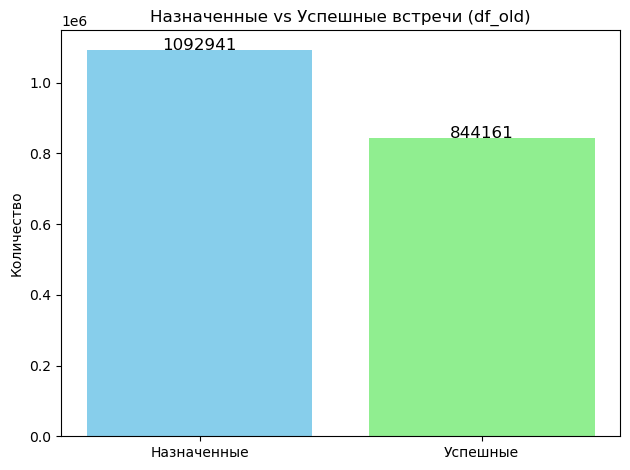

In [389]:
assigned = df_old['встреча назначена'].sum()
successful = df_old['встреча состоялась успешно'].sum()

plt.bar(['Назначенные', 'Успешные'], [assigned, successful], color=['skyblue', 'lightgreen'])
plt.title('Назначенные vs Успешные встречи (df_old)')
plt.ylabel('Количество')

for i, val in enumerate([assigned, successful]):
    plt.text(i, val + 5, str(int(val)), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

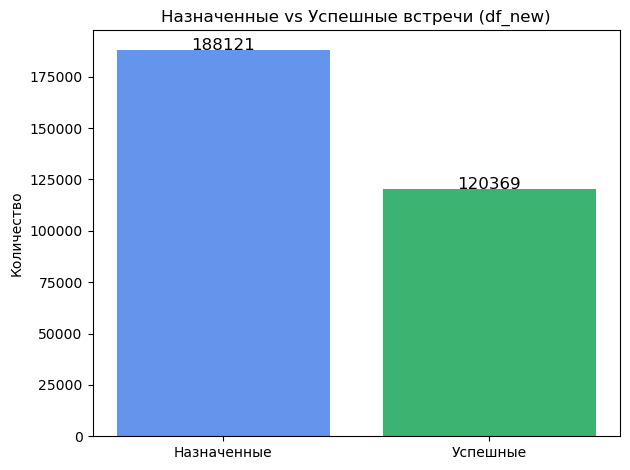

In [390]:
assigned = df_new['встреча назначена'].sum()
successful = df_new['встреча состоялась успешно'].sum()

plt.bar(['Назначенные', 'Успешные'], [assigned, successful], color=['cornflowerblue', 'mediumseagreen'])
plt.title('Назначенные vs Успешные встречи (df_new)')
plt.ylabel('Количество')

for i, val in enumerate([assigned, successful]):
    plt.text(i, val + 5, str(int(val)), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

Итак, мы видим, что с обновлением гексагонов количество успешных встреч уменьшилось. Мне стало интересно посмотреть общую статистику df по субъектам РФ. Возьмем топ-5 регионов

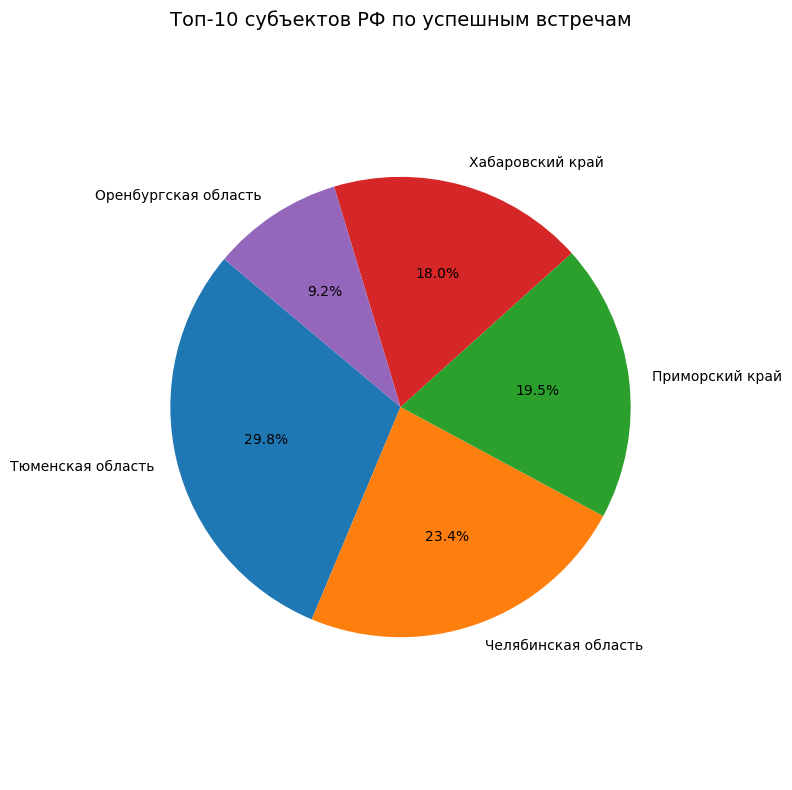

In [391]:
top_5 = (
    df.groupby('Субъект РФ')['встреча состоялась успешно']
    .sum()
    .sort_values(ascending=False)
    .head(5)
)

plt.figure(figsize=(8, 8))
plt.pie(
    top_subjects,
    labels=top_subjects.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.tab10.colors
)
plt.title('Топ-10 субъектов РФ по успешным встречам', fontsize=14)
plt.axis('equal') 
plt.tight_layout()
plt.show()

Теперь мы знаем топ-5 регионов, которые фанатеють от Тинька. Давайте, посмотрим изменился ли лидер по субъекам РФ после того, как банк поменят новый режим. Для этого мы подсчитаем количество записей по всем по всем регионам и найдем самый популярный, а затем посмотрим количество успешных встреч и назначенных

In [392]:
r = df_old['Субъект РФ'].value_counts()

# Самый частый регион
top_rgn = r.idxmax()
top_cnt = r.max()
rgn_df = df_old[df_old['Субъект РФ'] == top_rgn]

# Статистика встреч
meet = rgn_df['встреча назначена'].sum()
ok = rgn_df['встреча состоялась успешно'].sum()

print(f"""
Главные фанаты Тинька до изменения гексагонов жили в: {top_rgn}
В таблице их упоминали: {top_cnt}
Они хотели встретиться с представителями: {meet}
Но получилось встретиться всего: {ok}
""")


Главные фанаты Тинька до изменения гексагонов жили в: Челябинская область
В таблице их упоминали: 187953
Они хотели встретиться с представителями: 186611
Но получилось встретиться всего: 148205



In [393]:
reg = df_new['Субъект РФ'].value_counts()

# Самый частый
region = reg.idxmax()
count = reg.max()
df = df_new[df_new['Субъект РФ'] == region]

# Статистика по встречам
assigned = df['встреча назначена'].sum()
success = df['встреча состоялась успешно'].sum()

# Вывод
print(f"""
После нововведений Тинёк больше полюбили в: {region}
Жителей этого места упомянули: {count}
Они хотели встретиться с представителями: {assigned}
Но получилось встретиться всего: {success}
""")


После нововведений Тинёк больше полюбили в: Тюменская область
Жителей этого места упомянули: 44800
Они хотели встретиться с представителями: 44005
Но получилось встретиться всего: 32533



По изменениям конверсий в общем понятно. Мне стало интересно посмотреть на общие значения, например: Какую карту люди чаще всего заказывают?

In [394]:
top_types = df['тип карты'].value_counts()
top_types.reset_index()

,тип карты,count
0,Debit Card,39559
1,Credit Card,4519
2,Trading,720
3,Cash Loan,2


Довольно очевидные выводы, ладно. Напоследок вернемся к гексагонам: какие гексагоны первые претерпели изменения?

In [395]:
df['дата изменений'] = pd.to_datetime(df['дата изменений'])
df_sorted = df.sort_values(by='дата изменений')
first_change = df_sorted.drop_duplicates(subset='гексагон', keep='first')
top10 = first_change[['гексагон', 'дата изменений']].head(10)
print(top10)

                гексагон дата изменений
32       8810d9a441fffff     2022-08-12
1209468  8821659733fffff     2022-08-12
1209477  8810ca2d39fffff     2022-08-12
1209490  8810ca6905fffff     2022-08-12
1209509  8810d9aeb5fffff     2022-08-12
1209511  8810d9a66bfffff     2022-08-12
1209556  8810d9a64dfffff     2022-08-12
1209594  8810d9a6a5fffff     2022-08-12
1209602  8810d9b4ebfffff     2022-08-12
1209612  8810d9b401fffff     2022-08-12


C:\Users\Marusya\AppData\Local\Temp\ipykernel_9664\387111789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['дата изменений'] = pd.to_datetime(df['дата изменений'])


In [396]:
top10 = top10['гексагон'].tolist()
cities = df[df['гексагон'].isin(top10)][['гексагон', 'Субъект РФ']].drop_duplicates()
print(cities)

               гексагон         Субъект РФ
32      8810d9a441fffff  Тюменская область
1382    8810ca6905fffff  Тюменская область
2164    8810d9a64dfffff  Тюменская область
3077    8810d9a6a5fffff  Тюменская область
3646    8821659733fffff  Тюменская область
3715    8810d9a66bfffff  Тюменская область
3855    8810d9b4ebfffff  Тюменская область
32730   8810d9b401fffff  Тюменская область
126050  8810d9aeb5fffff  Тюменская область
160823  8810ca2d39fffff  Тюменская область
